In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

from absl import app
from absl import flags
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
import imageio
from tqdm import tqdm

import lighthouse.geometry.projector as pj
from lighthouse.mlv import MLV
import lighthouse.nets as nets

from scipy.spatial.transform import Rotation as R


In [5]:
mykey = lambda x:int(x.split(".")[0].split("_")[1])

def pose2H(pose):
    t = pose[-3:]
    q = pose[:4]
    q = q[[1,2,3,0]]
    Rot = R.from_quat(q).as_matrix()
    H = np.eye(4)
    H[:3,:3] = Rot
    H[:3,3] = t
    return H

def get_mbatch(id_ref=1,id_src=3,id_env=99):
    mbatch = {}

    mimage_root = "/home/wiss/lhao/junpeng/ws_lighthouse/data/setup_ptc/scene0370_02/pfm"
    mimage_dirs = sorted(os.listdir(mimage_root),key=mykey)

    # id_ref = 1
    mref_image_path = os.path.join(mimage_root,mimage_dirs[id_ref])
    # print(mref_image_path)

    mdepth_root = mimage_root.replace("pfm","depth")
    # mdepth_path = "/home/wiss/lhao/junpeng/ws_lighthouse/data/setup_ptc/scene0370_02/depth/bgrdepth_2.png"
    mdepth_path = os.path.join(mdepth_root,sorted(os.listdir(mdepth_root),key=mykey)[id_ref])
    
    mintrinsic = np.array([[577.8705679012345,0,320],[0,577.8705679012345,240],[0, 0, 1]])

    # ref_pose
    raw = np.loadtxt("/home/wiss/lhao/junpeng/ws_lighthouse/data/setup_ptc/scene0370_02/cam_poses0.txt")
    mref_pose = raw[id_ref,:]
    mt = mref_pose[-3:]
    mq = mref_pose[:4]
    mq = mq[[1,2,3,0]]
    mRot = R.from_quat(mq).as_matrix()
    mH = np.eye(4)
    mH[:3,:3] = mRot
    mH[:3,3] = mt

    # src_images
    # id_src = 3
    msrc_image_path = os.path.join(mimage_root,mimage_dirs[id_src])

    # src_pose
    msrc_pose = raw[id_src,:]
    mH_src = pose2H(msrc_pose)

    # env_pose
    # id_env = 99
    raw_env = np.loadtxt("/storage/user/lhao/hjp/ws_superpixel/output/test2_300/2frame0370_02/2frame0370_02_control_cam_pose.txt",skiprows=0)
    menv_pose = raw_env[id_env]
    mH_env = pose2H(menv_pose)[np.newaxis,...]

    mbatch["ref_image"] = cv2.imread(mref_image_path, cv2.IMREAD_UNCHANGED)[np.newaxis, ...]
    mbatch["ref_depth"] = cv2.imread(mdepth_path,cv2.CV_16UC1)[np.newaxis, ...]/5000.0
    mbatch["intrinsics"] = mintrinsic[np.newaxis, ...]
    mbatch["ref_pose"] = mH[np.newaxis, ...]
    mbatch["src_images"] = cv2.imread(msrc_image_path, cv2.IMREAD_UNCHANGED)[np.newaxis, ...]
    mbatch["src_poses"] = mH_src[np.newaxis,...,np.newaxis]
    mbatch["env_pose"] = mH_env.astype(np.float32)

    return mbatch
    
mbatch = get_mbatch()
print(mbatch["ref_image"].shape) # = 6 input image
print(mbatch["ref_depth"].shape) # = 6 input depth
print(mbatch["intrinsics"].shape)
print(mbatch["src_images"].shape)
print(mbatch["ref_pose"].shape)
print(mbatch["src_poses"].shape)
print(mbatch["env_pose"].shape)

(1, 480, 640, 3)
(1, 480, 640)
(1, 3, 3)
(1, 480, 640, 3)
(1, 4, 4)
(1, 4, 4, 1)
(1, 4, 4)


In [6]:
# data_dir = "./testset/test_set_with_coords_fixed/"
checkpoint_dir = "./lighthouse/model/"
# output_dir = "./lighthouse_output/"
output_dir = "/home/wiss/lhao/junpeng/ws_lighthouse/output_lzq2frame"

batch_size = 1  # implementation only works for batch size 1 currently.
height = 480  # px
width = 640  # px
env_height = 512  # px
env_width = 1024  # px
cube_res = 64  # px
theta_res = 240  # px
phi_res = 120  # px
r_res = 128  # px
scale_factors = [2, 4, 8, 16]
num_planes = 32
depth_clip = 20.0

In [7]:
print(tf.test.gpu_device_name())
print(tf.test.is_gpu_available())
print(tf.__version__)
print(tf.config.experimental.list_physical_devices(device_type="GPU"))
print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU'))) 

/device:GPU:0
True
1.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True
True
Num GPUs Available:  1


In [8]:
# Set up placeholders
ref_image = tf.placeholder(dtype=tf.float32, shape=[None, height, width, 3])
ref_depth = tf.placeholder(dtype=tf.float32, shape=[None, height, width])
intrinsics = tf.placeholder(dtype=tf.float32, shape=[None, 3, 3])
ref_pose = tf.placeholder(dtype=tf.float32, shape=[None, 4, 4])
src_images = tf.placeholder(dtype=tf.float32, shape=[None, height, width, 3])
src_poses = tf.placeholder(dtype=tf.float32, shape=[None, 4, 4, 1])
env_pose = tf.placeholder(dtype=tf.float32, shape=[None, 4, 4])

# Set up model
model = MLV()

# We use the true depth bounds for testing
# Adjust to estimated bounds for your dataset
min_depth = tf.reduce_min(ref_depth)
max_depth = tf.reduce_max(ref_depth)

mpi_planes = pj.inv_depths(min_depth, max_depth, num_planes)

pred = model.infer_mpi(src_images, ref_image, ref_pose, src_poses, intrinsics,
                        mpi_planes)
rgba_layers = pred["rgba_layers"]

mpi_gt = model.img2mpi(ref_image,ref_depth,mpi_planes)

lightvols, lightvol_centers, \
lightvol_side_lengths, \
cube_rel_shapes, \
cube_nest_inds = model.predict_lighting_vol(mpi_gt, mpi_planes,
                                            intrinsics, cube_res,
                                            scale_factors,
                                            depth_clip=depth_clip)
lightvols_out = nets.cube_net_multires(lightvols, cube_rel_shapes,
                                        cube_nest_inds)
output_envmap, all_shells_list = model.render_envmap(lightvols_out, lightvol_centers,
                                        lightvol_side_lengths, cube_rel_shapes,
                                        cube_nest_inds, ref_pose, env_pose,
                                        theta_res, phi_res, r_res)

Instructions for updating:
Use `tf.cast` instead.

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.keras.layers.Conv3D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.





In [10]:
id_ref=1
id_src=3
id_env=101

config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )

sess1 = tf.Session(config=config)

with sess1 as sess:
    saver = tf.train.Saver()
    saver.restore(sess, os.path.join(checkpoint_dir, "model.ckpt"))

    # i = 0
    # for i in range(0, len(input_files)):
    # print("running example:", i)

    # Load inputs
    # batch = np.load(data_dir + input_files[i])
    for id_env in tqdm(range(260)):
        if id_ref == id_src:
            continue
        batch = get_mbatch(id_ref,id_src,id_env)
    
        output_lightvols_out_eval, output_lightvols_eval, output_envmap_eval, output_lightvol_centers_eval,all_shells_list_eval = sess.run(
            [lightvols_out, lightvols, output_envmap, lightvol_centers,all_shells_list],
            feed_dict={
                ref_image: batch["ref_image"],
                ref_depth: batch["ref_depth"],
                intrinsics: batch["intrinsics"],
                ref_pose: batch["ref_pose"],
                src_images: batch["src_images"],
                src_poses: batch["src_poses"],
                env_pose: batch["env_pose"]
            })
            
        rgb = output_envmap_eval.squeeze()[:,:,[2,1,0]]
        output_path = os.path.join(output_dir,"env_ref{}_{}.pfm".format(str(id_ref),str(id_env+1)))
        # plt.imsave(output_path,rgb)
        imageio.imwrite(output_path, rgb, format='PFM')
        
    

INFO:tensorflow:Restoring parameters from ./lighthouse/model/model.ckpt


100%|██████████| 260/260 [12:01<00:00,  2.77s/it]


In [26]:
imageio.imwrite(output_path, rgb, format='PFM')

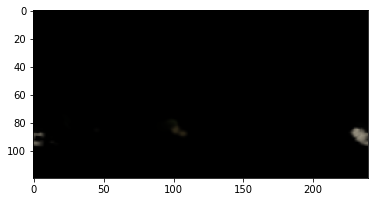

In [20]:
plt.imshow(rgb)

# Devel

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


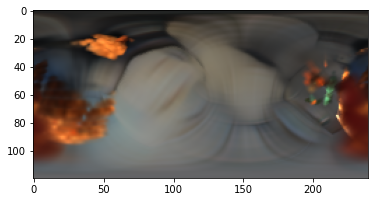

In [26]:
# plt.imshow(rgba[:,:,0,:])
plt.imshow(output_envmap_eval.squeeze()[:,:,[2,1,0]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


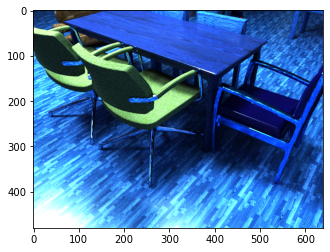

In [14]:
plt.imshow(batch["ref_image"].squeeze())

In [49]:
print(output_lightvols_out_eval[0].shape) # (1, 64, 64, 64, 4)
print(output_lightvols_eval[0].shape) # (1, 64, 64, 64, 4)
print(output_lightvol_centers_eval[4])
print(all_shells_list_eval[0].shape)

(1, 64, 64, 64, 4)
(1, 64, 64, 64, 4)
[[0.        0.        0.6070476]]
(1, 120, 240, 128, 4)
